# AT&T Spams detector

## Loading the data and libraries

In [1]:
# librairies usuelles
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

# librairies qui vont servir lors du preprocessing textuel
import datetime
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import re

# librairies pour nos modèles : Tensorflow et Transformers de Hugging Face (pour les modèles pré-entraînés)
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM, Dropout
# classes et méthodes de Scikit-Learn pour le préprocessing, le splitting, les métriques, etc...
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score

# On importe également les plugings params pour Tensorboard, pour le tracking des performances de nos modèles
from tensorboard.plugins.hparams import api as hp
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import vocabulary package
# Charger le modèle de langue anglais
!python -m spacy download en_core_web_md


2023-12-19 11:06:20.763963: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 11:06:20.764030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 11:06:20.765315: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 11:06:22.039439: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 14.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [3]:
# Load dataset

data = pd.read_csv('./spam.csv', encoding = 'ISO-8859-1')
print(data.head())

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [4]:

# Compter le nombre de valeurs NaN pour chaque colonne
nan_counts = data.isna().sum()

print("Nombre de valeurs NaN par colonne :")
print(nan_counts)

Nombre de valeurs NaN par colonne :
v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64


In [5]:
# Supprimer les colonnes qui contiennent plus de 50% de valeurs NaN

data = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
print(data.head())
print(data.shape)

print("\n Nombre de hams et de span: \n", data['v1'].value_counts())

     v1                                                 v2
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
(5572, 2)

 Nombre de hams et de span: 
 ham     4825
spam     747
Name: v1, dtype: int64


# Preprocessing

## Nettoyage du texte

In [6]:
# remove poncutuations and convert to lower cases

data['v2_clean'] = data['v2'].apply(lambda s : re.sub(r'[^\w\s]', '', s).lower())
data.head()

,v1,v2,v2_clean
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


## Lemmatisation et tokenisation

In [7]:
# lemmatize
nlp = spacy.load('en_core_web_md')
data["v2_lemma"] = data["v2_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))
data.head()


,v1,v2,v2_clean,v2_lemma
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah think usf live


In [8]:
## tokenisation

# Créer un objet Tokenizer avec un vocabulaire maximal de 2000 mots et un token "out_of_vocab" pour les mots hors vocabulaire
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=2000, oov_token="out_of_vocab")

# Adapter le tokenizer aux textes de la colonne 'v2_lemma' de la variable 'data'
tokenizer.fit_on_texts(data['v2_lemma'])

# Obtenir la taille du vocabulaire (nombre de mots) basée sur le nombre maximal de mots spécifié
vocab_size = tokenizer.num_words
print(vocab_size)
# afficher le mapping entre les indices et les mots du vocabulaire construits à partir de la colonne 'v2_lemma'
# Transformer les textes de la colonne 'v2_lemma' en séquences d'entiers en utilisant le tokenizer
data["v2_tokenized"] = tokenizer.texts_to_sequences(data['v2_lemma'])
print(tokenizer.index_word)

# Afficher les premières lignes du DataFrame 'data' pour visualiser les résultats
print(data.head())


2000
{1: 'out_of_vocab', 2: 'u', 3: 'm', 4: '2', 5: 'ur', 6: 'come', 7: 's', 8: '4', 9: 'know', 10: 'ok', 11: 'ltgt', 12: 'free', 13: 'good', 14: 'send', 15: 'like', 16: 'want', 17: 'day', 18: 'ill', 19: 'time', 20: 'love', 21: 'text', 22: 'tell', 23: 'think', 24: 'need', 25: 'txt', 26: 'home', 27: 'lor', 28: 'reply', 29: 'stop', 30: 'sorry', 31: 'r', 32: 'd', 33: 'win', 34: 'mobile', 35: 'today', 36: 'n', 37: 'phone', 38: 'new', 39: 'week', 40: 'later', 41: 'work', 42: 'ask', 43: 'da', 44: 'hi', 45: 'miss', 46: 'ì', 47: 'hope', 48: 'night', 49: 'claim', 50: 'meet', 51: 'wait', 52: 'thing', 53: 'great', 54: 'try', 55: 'oh', 56: 'leave', 57: 'hey', 58: 'dear', 59: 'pls', 60: 'wat', 61: 'happy', 62: 'message', 63: 'number', 64: 'friend', 65: 'feel', 66: 'thank', 67: 'way', 68: 've', 69: 'late', 70: 'prize', 71: 'right', 72: 'msg', 73: 'find', 74: 'pick', 75: 'tomorrow', 76: 'yes', 77: 'let', 78: 'yeah', 79: 'e', 80: '1', 81: 'babe', 82: 'amp', 83: 'sleep', 84: 'min', 85: 'c', 86: 'life',

In [9]:
print(data.v1.value_counts())

ham     4825
spam     747
Name: v1, dtype: int64


In [10]:
#supression de l'étape de padding pour l'ffectuer après l'oversampling / unersampling
#data_pad = tf.keras.preprocessing.sequence.pad_sequences(data.v2_tokenized, padding="post")

### Ensemble de données d'entrainement / test et de validation

In [11]:
# split train test sets with 0.13 due to
data_train_test, data_val = train_test_split(data, test_size=0.13, stratify=data['v1'], random_state=2)
print(data_train_test)
print(data_val)

        v1                                                 v2  \
4209   ham  No da:)he is stupid da..always sending like th...   
3507   ham  Camera quite good, 10.1mega pixels, 3optical a...   
3325   ham  Huh so fast... Dat means u havent finished pai...   
2522   ham  Dunno lei... I might b eatin wif my frens... I...   
3933   ham   How come guoyang go n tell her? Then u told her?   
...    ...                                                ...   
1386   ham                        All e best 4 ur exam later.   
1271   ham  If you still havent collected the dough pls le...   
672   spam  Get ur 1st RINGTONE FREE NOW! Reply to this ms...   
2991   ham          K.i did't see you.:)k:)where are you now?   
2658   ham                         Not yet chikku..wat abt u?   

                                               v2_clean  \
4209  no dahe is stupid daalways sending like thisdo...   
3507  camera quite good 101mega pixels 3optical and ...   
3325   huh so fast dat means u havent fini

On travaille sur une tâche de classification où les classes sont déséquilibrées (il y a environ 6 fois plus de ham que de spams), donc on utilise la stratification pour s' assurer que la proportion de chaque classe est maintenue dans les ensembles dde train et test.

De plus, les hams représentent 87% des données, alors que les spams représentent seulement 13%. On va donc sélectionner un test size donc on choisit la valeur de l'argument test_size de manière à maintenir la même proportion entre les classes dans l'ensemble de test que dans l'ensemble d'entraînement. Cela garantit que notre modèle est évalué de manière équitable sur toutes les classes

In [12]:
def data_under_sampling(data, nb_reduce):
  """
    Sous-échantillonnage des données pour équilibrer les classes.

    Args:
    - data (DataFrame): Le DataFrame contenant les données.
    - nb_reduce (int): Le facteur de réduction pour la classe majoritaire.

    Returns:
    - DataFrame: Le DataFrame équilibré après sous-échantillonnage.
    """
  data_sample_2 = data.loc[data['v1']=='spam',:]
  len_class_sub = len(data_sample_2)
  data_sample_1 = data.loc[data['v1']=='ham',:].sample(nb_reduce * len_class_sub)
  return pd.concat([data_sample_1,data_sample_2], axis=0).sample(frac=1).reset_index(drop=True)

data_red = data_under_sampling(data_train_test, 4)
#print(data_red.head())
print(data_red.shape)
print(data_red['v1'].value_counts())





(3250, 5)
ham     2600
spam     650
Name: v1, dtype: int64


In [13]:
# calcule la longueur maximale d'une séquence de tokens dans la colonne 'v2_tokenized' pour avoir une base pour le padding

max_len_sentence = max([len(token) for token in data['v2_tokenized'].to_list()])
max_len_sentence



72

In [14]:
# on applique le padding
v2_pad_train = tf.keras.preprocessing.sequence.pad_sequences(data_red['v2_tokenized'], padding="post", maxlen=max_len_sentence)
v2_pad_val = tf.keras.preprocessing.sequence.pad_sequences(data_val['v2_tokenized'], padding="post", maxlen=max_len_sentence)

### target preprocessing

In [15]:
preprocessor_y = LabelEncoder()
data['v1'] = preprocessor_y.fit_transform(data['v1'])

y_train_test = preprocessor_y.transform(data_red['v1'])
y_val = preprocessor_y.transform(data_val['v1'])


Après avoir appliqué les prétraitements appropriés (cleaning, lemmatisation, toknization, undersampling et padding) sur les données d'entraînement et de test d'une part, et sur l'ensemble de données de validation d'autre part, nous pouvons procéder à une deuxième division pour créer les ensembles distincts d'entraînement et de test à partir de de l'ensemble de données train_test dédié. Tout comme lors de la première division, nous utilisons une stratification pour garantir que les proportions des classes cibles sont maintenues dans les deux ensembles, assurant ainsi une répartition équilibrée des données de chaque classe dans les ensembles d'entraînement et de test.

In [16]:
x_train, x_test, y_train, y_test = train_test_split(v2_pad_train, y_train_test, test_size=0.15, stratify=y_train_test, random_state=2)

On prépare les données d'entraînement et de test sous forme de datasets TensorFlow, prêtes à être utilisées lors de l'entraînement d'un modèle de deep learning. Les échantillons sont mis en lots, mélangés (pour les données d'entraînement).

In [17]:
BATCH_SIZE = 64
train_batch = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(BATCH_SIZE)
test_batch = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)



In [18]:
print('Preprocessing done --- extract of test_batch : ')
for sentence, target in test_batch.take(1):
  print(sentence, target)

Preprocessing done --- extract of test_batch : 
tf.Tensor(
[[   1    3  444 ...    0    0    0]
 [  12  303  489 ...    0    0    0]
 [1517  231  796 ...    0    0    0]
 ...
 [  57  296    0 ...    0    0    0]
 [  74   37   71 ...    0    0    0]
 [   6    2    0 ...    0    0    0]], shape=(64, 72), dtype=int32) tf.Tensor(
[0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 0 1
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0], shape=(64,), dtype=int64)


# Modeling testing

Nous allons tester trois types de modèles Séquentiels, RNN et CNN et tester également différentes architecture de couches de neurones pour chacun des type de réseaux.

4 architectures pour chaque modèle sequentiel, RNN et CNN on été testées. les Résultats sont présentés sont la forme d'un tableau dans la partie analyse.

### Métriques d'analyse

Trois métriques sont utilisées pour évaluer les performances des différents modèles testés.

- Le taux d'accuracy, qui est calculé comme le rapport entre le
- Le taux de précision , qui est calculé comme le rapport entre le
- Le taux de recall, qui est calculé comme le rapport entre le nombre de vrais positifs et la somme des vrais positifs et des faux négatifs. La formule est la suivante :
Recall=
(TP+FN)/TP
où TP est le nombre de vrais positifs et FN est le nombre de faux négatifs.

On choisit la mesure Binary Crossentropy comme fonction de coût utilisée pendant l'entraînement pour guider l'optimisation du modèle.

Nous construisons une fonction pour compiler et entrainer les différents  modèle de réseaux neuronaux testés .



On utilise la fonction pandas value_counts pour créer un dictionnaire qui assigne à chaque valeur de la variable cible un poids qui est inversement proportionnel à leur fréquence dans le dataset. Ce

In [19]:
def compile(model, model_name='default'):
  # definition de l'optimiseur - on utilise Adam()
  optimizer= tf.keras.optimizers.Adam()
  # lors de la compilation, pour la loss on prend
  model.compile(optimizer="adam",
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])
  log_dir="logs/fit/" + model_name + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
  print (f"{model} logged with name : {model_name}...")
  return tensorboard_callback

def fit_model(model, train_batch, epoch, test_batch, tensorboard_callback):
  history = model.fit(
    train_batch,
    epochs=epoch,
    verbose=1,
    callbacks=[tensorboard_callback],
    validation_data=test_batch)
  return history


#### Analysis

On crée une fonction pour convertir les prédictions probabilistes du modèle (probabilités continues entre 0 et 1) en prédictions binaires (0 ou 1) en utilisant un seuil spécifié. Cela nous servira pour ajuster le point de décision pour la classification binaire en fonction de nos besoins spécifiques comme par exemple pour améliorer la précision ou le rappel en ajustant le seuil de décision.

Ensuite une fonction est créée pour afficher une matrice de confusion pour visualiser les performances de prédictions des modèles.

Puis nous créons finalement une fonction qui permet d'enregistrer  les trois métriques de performance des différents modèles dans un tableau.

In [20]:


def predictions_singleton_to_binary(model, tresh, x_val, y_val):
  y_true = y_val
  y_pred = np.where(model.predict(x_val) > tresh, 1, 0)
  return y_true, y_pred

  # Affichage des matrices de confusion

def display_matrix_and_scores(y_true, y_pred):
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
  print(f'Accuracy : {accuracy_score(y_true,y_pred)}')
  print(f'Precision : {precision_score(y_true,y_pred)}')
  print(f'Recall : {recall_score(y_true,y_pred)}')


  # Fonction pour ajouter les résultats d'un modèle au DataFrame
def add_results_to_df(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    # Ajouter une nouvelle ligne au DataFrame
    global results_df
    results_df = results_df.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    }, ignore_index=True)




#### Modèles séquentiels

Nous instancions 4 modèles séquentiels dont les couches de neurones qui les composent sont différentes.

Le modèle 1 est un premier modèle classique avec une architecture simple. Pour un problème de classification de messages ham et spam, une taille d'embedding typique pourrait se situer entre 50 et 300 dimensions, nous allons tester une dimension d'embedding de 128 pour commencer. Nous commençons par tester un modèle avec une unique couche dense pour commencer et nous verrons si le fait de rajouter une couche dropout dans le modèle 2 améliore la tache de classification.

L'ajout d'une couche Dropout dans le modèle 2 est une technique de régularisation qui aide à prévenir le surajustement dans les réseaux de neurones. En l'absence de la couche Dropout, le modèle peut avoir tendance à surapprendre les détails spécifiques du jeu de données d'entraînement, ce qui peut conduire à une performance médiocre sur de nouvelles données (overfitting). La couche Dropout introduit une régularisation en désactivant aléatoirement certains neurones pendant l'entraînement, forçant ainsi le réseau à apprendre de manière plus robuste. Nous allons voir si elle est utile dans notre cas.

Le modèle 3 présentera quant à lui une couche dense supplémentaires avec 32 neurones rajoutée avant la couche dropout et le modèle 4 aura 2 couches dense supplémentaires, l'une de 32 neurones avant la couche droupout et une autre couche avec 32 neurones après la couche dropout


In [21]:

model_1 = tf.keras.Sequential([
                  # Couche d'Input Word Embedding
                  tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[data[['v1']].shape[1],],name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(64, activation='relu'),
                  tf.keras.layers.Dense(1, activation="sigmoid")

])

model_2 = tf.keras.Sequential([
                  tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[x_train.shape[1],],name="embedding"),
                  tf.keras.layers.GlobalAveragePooling1D(),
                  tf.keras.layers.Dense(64, activation='relu'),
                  tf.keras.layers.Dropout(0.2),
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[x_train.shape[1],], name="embedding"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),  # Nouvelle couche Dense
    tf.keras.layers.Dropout(0.2),
#    tf.keras.layers.Dense(16, activation='relu'),  # Nouvelle couche Dense
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 128, input_shape=[x_train.shape[1],], name="embedding"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),  # Nouvelle couche Dense
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),  # Nouvelle couche Dense
    tf.keras.layers.Dense(1, activation="sigmoid")
])


for model in [model_1, model_2, model_3,model_4]:
  model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 128)            256128    
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 264449 (1.01 MB)
Trainable params: 264449 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
________________________________________________________________

On boucle à présent sur les 4 modèles précedemment définis pour les entrainer en premier temps.

Puis dans un deuxième temps pour tracer des courbes d'apprentissage qui montrent l'évolution de la perte et des métriques sur l'ensemble d'entraînement et de validation au fil des epochs. Cela permet d'avoir une visualisation plus globale des performances du modèle.

Dans un troisième temps affichons les matrices de confusion associées à chaque modèle d'eux et finalement nous enregistrons toutes les métriques de performances pour les 4 modèles dans le tableau définis auparavant.

<keras.src.engine.sequential.Sequential object at 0x7853ec857190> logged with name : default...
Epoch 1/20
44/44 [==============================] - 2s 22ms/step - loss: 0.5824 - accuracy: 0.7831 - precision: 0.1867 - recall: 0.0254 - val_loss: 0.4730 - val_accuracy: 0.7992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
44/44 [==============================] - 1s 23ms/step - loss: 0.4499 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4376 - val_accuracy: 0.7992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
44/44 [==============================] - 1s 28ms/step - loss: 0.4044 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3768 - val_accuracy: 0.7992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
44/44 [==============================] - 1s 29ms/step - loss: 0.3124 - accuracy: 0.8302 - precision: 0.9368 - recall: 0.1612 - val_loss: 0.2756 - val_accuracy: 0.8689 - val_precision: 

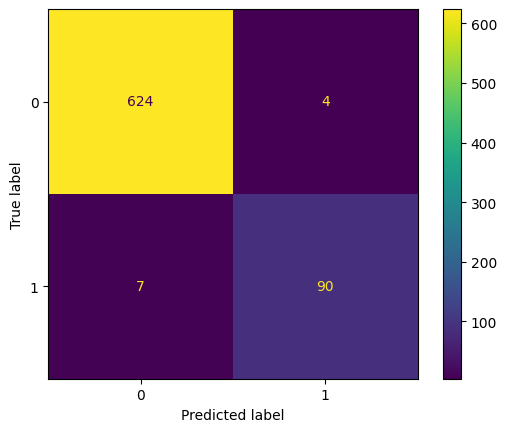

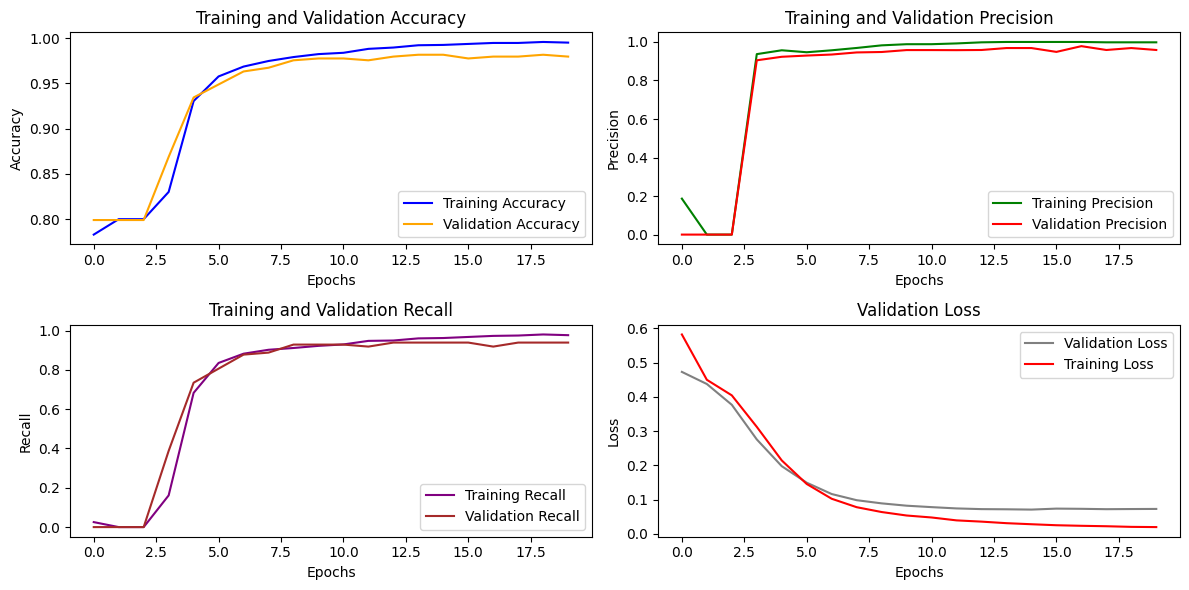

<keras.src.engine.sequential.Sequential object at 0x7853f983b460> logged with name : default...
Epoch 1/20
44/44 [==============================] - 5s 32ms/step - loss: 0.5548 - accuracy: 0.7983 - precision: 0.3077 - recall: 0.0072 - val_loss: 0.4651 - val_accuracy: 0.7992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
44/44 [==============================] - 1s 20ms/step - loss: 0.4476 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4331 - val_accuracy: 0.7992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
44/44 [==============================] - 1s 17ms/step - loss: 0.3954 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.3610 - val_accuracy: 0.7992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
44/44 [==============================] - 1s 12ms/step - loss: 0.2944 - accuracy: 0.8497 - precision: 0.9477 - recall: 0.2627 - val_loss: 0.2572 - val_accuracy: 0.8893 - val_precision: 

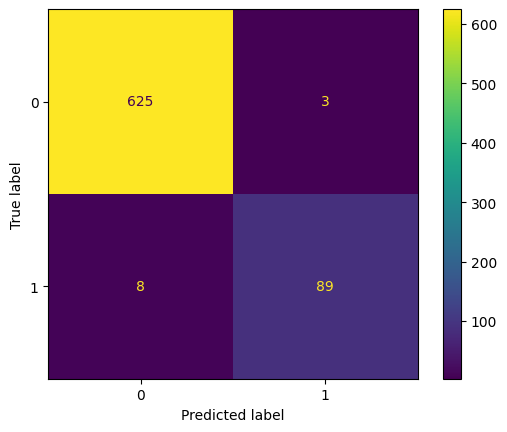

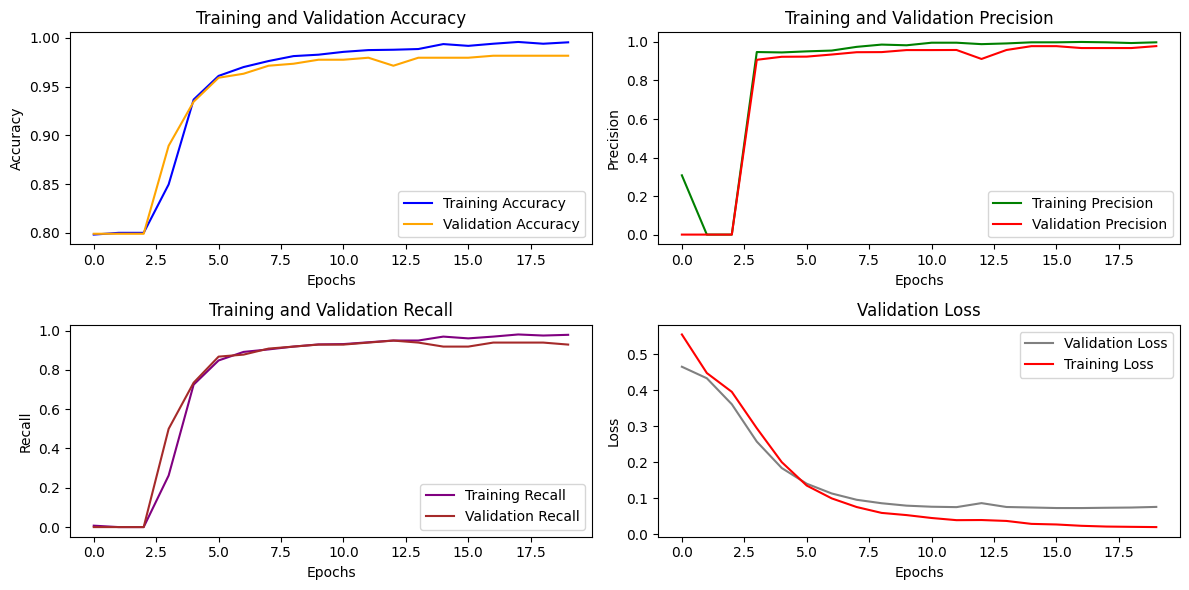

<keras.src.engine.sequential.Sequential object at 0x7853fc105ea0> logged with name : default...
Epoch 1/20
44/44 [==============================] - 2s 18ms/step - loss: 0.5503 - accuracy: 0.7991 - precision: 0.2000 - recall: 0.0018 - val_loss: 0.4699 - val_accuracy: 0.7992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
44/44 [==============================] - 1s 11ms/step - loss: 0.4488 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4244 - val_accuracy: 0.7992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
44/44 [==============================] - 1s 13ms/step - loss: 0.3662 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2982 - val_accuracy: 0.8258 - val_precision: 0.8421 - val_recall: 0.1633
Epoch 4/20
44/44 [==============================] - 0s 11ms/step - loss: 0.2130 - accuracy: 0.9247 - precision: 0.9479 - recall: 0.6594 - val_loss: 0.1620 - val_accuracy: 0.9508 - val_precision: 0.9111 -

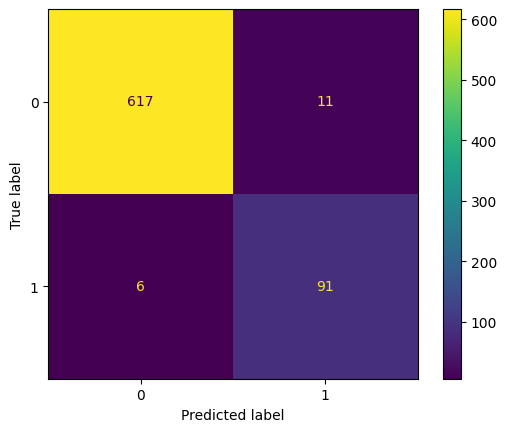

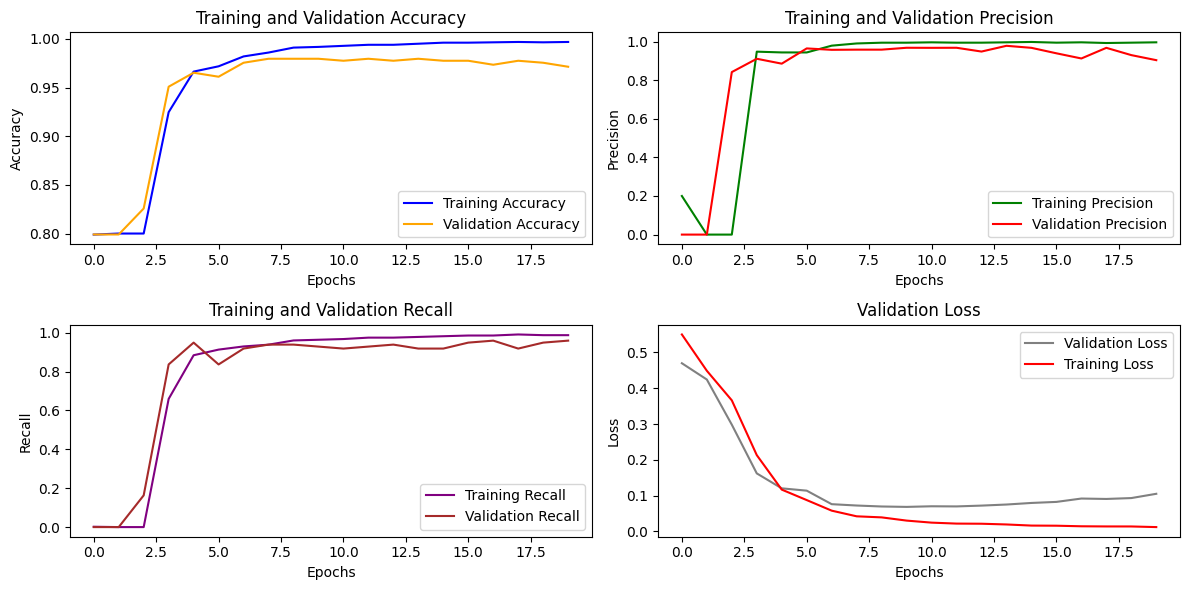

<keras.src.engine.sequential.Sequential object at 0x7853e876d8d0> logged with name : default...
Epoch 1/20
44/44 [==============================] - 2s 18ms/step - loss: 0.5637 - accuracy: 0.7972 - precision: 0.1000 - recall: 0.0018 - val_loss: 0.4681 - val_accuracy: 0.7992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
44/44 [==============================] - 1s 13ms/step - loss: 0.4533 - accuracy: 0.8001 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4258 - val_accuracy: 0.7992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
44/44 [==============================] - 1s 16ms/step - loss: 0.3570 - accuracy: 0.8012 - precision: 1.0000 - recall: 0.0054 - val_loss: 0.2710 - val_accuracy: 0.8852 - val_precision: 0.9038 - val_recall: 0.4796
Epoch 4/20
44/44 [==============================] - 1s 18ms/step - loss: 0.1922 - accuracy: 0.9504 - precision: 0.9406 - recall: 0.8025 - val_loss: 0.1397 - val_accuracy: 0.9549 - val_precision: 0.9222 - val_rec

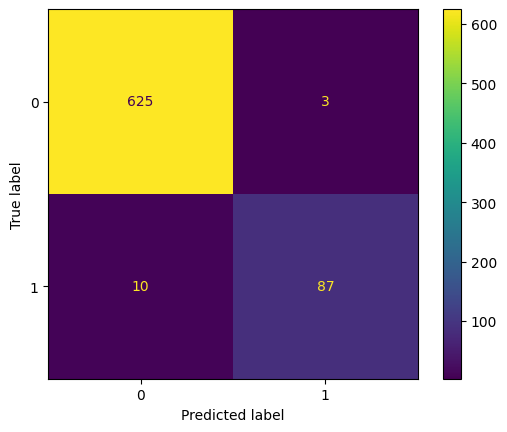

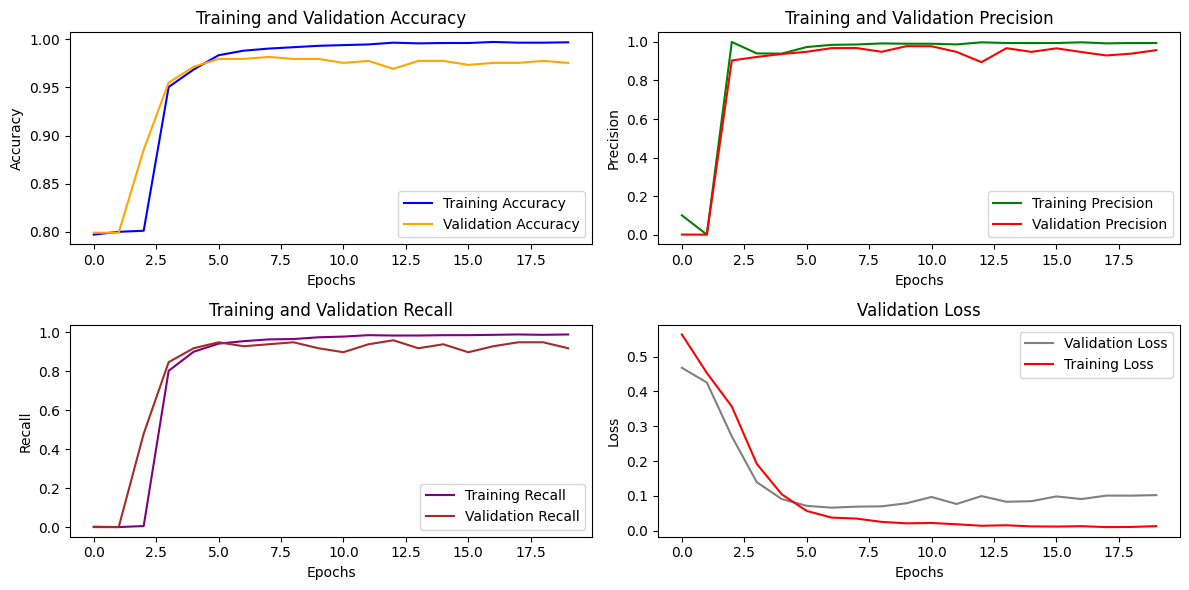

                                               Model  Accuracy  Precision  \
0  <keras.src.engine.sequential.Sequential object...  0.984828   0.957447   
1  <keras.src.engine.sequential.Sequential object...  0.984828   0.967391   
2  <keras.src.engine.sequential.Sequential object...  0.976552   0.892157   
3  <keras.src.engine.sequential.Sequential object...  0.982069   0.966667   

     Recall  
0  0.927835  
1  0.917526  
2  0.938144  
3  0.896907  


In [22]:
def training_analysis(model, test_batch, train_batch, tensorboard_callback):
  model_name = str(model)
  tresh = 0.5
  tensorboard_callback = tensorboard_callback
  test_batch = test_batch
  train_batch =train_batch
  epoch=20
#  fit_model(model, train_batch, epoch, test_batch, tensorboard_callback)
  # Appel de la fonction fit_model
  history = fit_model(model, train_batch, epoch=epoch, test_batch=test_batch, tensorboard_callback=tensorboard_callback)
  y_true, y_pred = predictions_singleton_to_binary(model, tresh, v2_pad_val, y_val)
  add_results_to_df(model_name, y_true, y_pred)
  print("\n\n Matrice de confusion : \n\n")
  display_matrix_and_scores(y_true, y_pred)
  print("\n\n Evolution des métriques : \n\n")
  # Accéder aux métriques
  accuracy = history.history['accuracy']
  precision = history.history['precision']
  recall = history.history['recall']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  val_accuracy = history.history['val_accuracy']
  val_precision = history.history['val_precision']
  val_recall = history.history['val_recall']


  # Créer des graphiques pour les métriques d'entraînement
  plt.figure(figsize=(12, 6))

  plt.subplot(2, 2, 1)
  plt.plot(accuracy, label='Training Accuracy', color='blue')
  plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(2, 2, 2)
  plt.plot(precision, label='Training Precision', color='green')
  plt.plot(val_precision, label='Validation Precision', color='red')
  plt.title('Training and Validation Precision')
  plt.xlabel('Epochs')
  plt.ylabel('Precision')
  plt.legend()

  plt.subplot(2, 2, 3)
  plt.plot(recall, label='Training Recall', color='purple')
  plt.plot(val_recall, label='Validation Recall', color='brown')
  plt.title('Training and Validation Recall')
  plt.xlabel('Epochs')
  plt.ylabel('Recall')
  plt.legend()

  plt.subplot(2, 2, 4)
  plt.plot(val_loss, label='Validation Loss', color='gray')
  plt.plot(loss, label='Training Loss', color='red')
  plt.title('Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()
# Créer un DataFrame vide pour stocker les résultats
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall'])
for model in [model_1, model_2, model_3,model_4]:
  tensorboard_callback = compile(model)
  training_analysis(model,test_batch, train_batch, tensorboard_callback)

print(results_df)



Les métriques de précision, d'accuracy et de recall augmentent au cours des epochs jusqu'à atteindre un palier vers la 5e epoch et la loss diminue sur les ensembles d'entrainement et de test. cela suggère  que le modèle apprend bien à partir des données d'entraînement.
Le modèle 4 semble présenter de légères meilleurs performances pour les métrique d'accuracy et de précision (pas celle de rappel) ce qui suggère que la couche dropout pour régulariser est utile et que le rajout de couches dense aussi.
Je vais tenter de voir si les résultats sont encore meilleurs en appliquant une pondérations pour gérer le problème de désequilibre des classes au lieu d'utiliser la méthode d'undersampling.

In [23]:
print((data["v1"]).value_counts())
weights = 1/(data["v1"]).value_counts()
weights = weights * len(data)/2
weights = {index : values for index , values in zip(weights.index,weights.values)}
weights

0    4825
1     747
Name: v1, dtype: int64


{0: 0.5774093264248704, 1: 3.72958500669344}

In [24]:
def fit_model_weights(model, train_batch, epoch, test_batch, tensorboard_callback, weights):
  history = model.fit(
    train_batch,
    epochs=epoch,
    verbose=1,
    callbacks=[tensorboard_callback],
    validation_data=test_batch,
    class_weight=weights)
  return history

def training_analysis_weights(model, test_batch, train_batch, tensorboard_callback, weights):
  model_name = str(model)
  tresh = 0.5
  tensorboard_callback = tensorboard_callback
  test_batch = test_batch
  train_batch =train_batch
  epoch=20
#  fit_model(model, train_batch, epoch, test_batch, tensorboard_callback)
  # Appel de la fonction fit_model
  history = fit_model_weights(model, train_batch, epoch=epoch, test_batch=test_batch, tensorboard_callback=tensorboard_callback, weights=weights)
  y_true, y_pred = predictions_singleton_to_binary(model, tresh, v2_pad_val, y_val)
  add_results_to_df(model_name, y_true, y_pred)
  print("\n\n Matrice de confusion : \n\n")
  display_matrix_and_scores(y_true, y_pred)
  print("\n\n Evolution des métriques : \n\n")
  # Accéder aux métriques
  accuracy = history.history['accuracy']
  precision = history.history['precision']
  recall = history.history['recall']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  val_accuracy = history.history['val_accuracy']
  val_precision = history.history['val_precision']
  val_recall = history.history['val_recall']


  # Créer des graphiques pour les métriques d'entraînement
  plt.figure(figsize=(12, 6))

  plt.subplot(2, 2, 1)
  plt.plot(accuracy, label='Training Accuracy', color='blue')
  plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(2, 2, 2)
  plt.plot(precision, label='Training Precision', color='green')
  plt.plot(val_precision, label='Validation Precision', color='red')
  plt.title('Training and Validation Precision')
  plt.xlabel('Epochs')
  plt.ylabel('Precision')
  plt.legend()

  plt.subplot(2, 2, 3)
  plt.plot(recall, label='Training Recall', color='purple')
  plt.plot(val_recall, label='Validation Recall', color='brown')
  plt.title('Training and Validation Recall')
  plt.xlabel('Epochs')
  plt.ylabel('Recall')
  plt.legend()

  plt.subplot(2, 2, 4)
  plt.plot(val_loss, label='Validation Loss', color='gray')
  plt.plot(loss, label='Training Loss', color='red')
  plt.title('Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

<keras.src.engine.sequential.Sequential object at 0x7853ec857190> logged with name : default...
Epoch 1/20
44/44 [==============================] - 2s 20ms/step - loss: 0.0346 - accuracy: 0.9942 - precision: 0.9786 - recall: 0.9928 - val_loss: 0.0730 - val_accuracy: 0.9775 - val_precision: 0.9485 - val_recall: 0.9388
Epoch 2/20
44/44 [==============================] - 1s 13ms/step - loss: 0.0305 - accuracy: 0.9946 - precision: 0.9838 - recall: 0.9891 - val_loss: 0.0955 - val_accuracy: 0.9713 - val_precision: 0.9038 - val_recall: 0.9592
Epoch 3/20
44/44 [==============================] - 1s 12ms/step - loss: 0.0271 - accuracy: 0.9971 - precision: 0.9928 - recall: 0.9928 - val_loss: 0.0909 - val_accuracy: 0.9734 - val_precision: 0.9126 - val_recall: 0.9592
Epoch 4/20
44/44 [==============================] - 1s 13ms/step - loss: 0.0256 - accuracy: 0.9953 - precision: 0.9838 - recall: 0.9928 - val_loss: 0.0868 - val_accuracy: 0.9734 - val_precision: 0.9126 - val_recall: 0.9592
Epoch 5/20
4

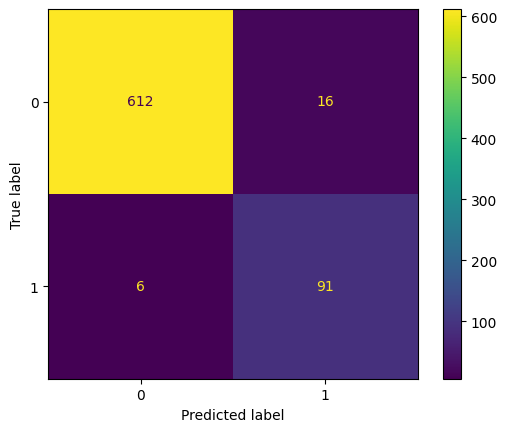

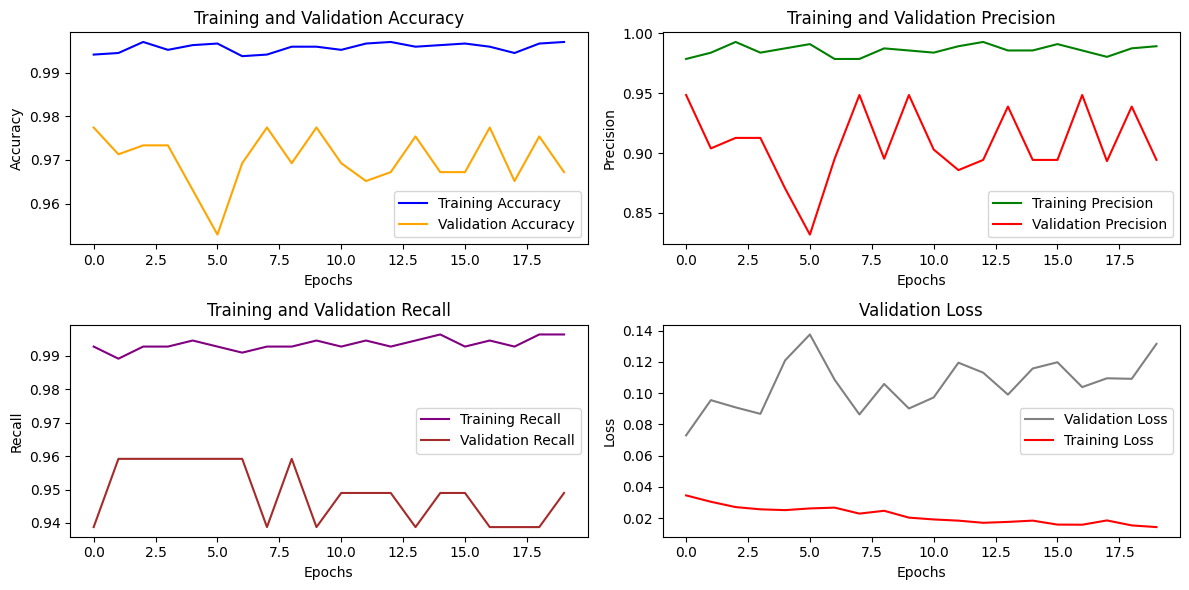

<keras.src.engine.sequential.Sequential object at 0x7853f983b460> logged with name : default...
Epoch 1/20
44/44 [==============================] - 2s 17ms/step - loss: 0.0355 - accuracy: 0.9931 - precision: 0.9750 - recall: 0.9909 - val_loss: 0.0906 - val_accuracy: 0.9693 - val_precision: 0.8952 - val_recall: 0.9592
Epoch 2/20
44/44 [==============================] - 1s 11ms/step - loss: 0.0311 - accuracy: 0.9953 - precision: 0.9856 - recall: 0.9909 - val_loss: 0.0887 - val_accuracy: 0.9693 - val_precision: 0.8952 - val_recall: 0.9592
Epoch 3/20
44/44 [==============================] - 1s 12ms/step - loss: 0.0285 - accuracy: 0.9949 - precision: 0.9838 - recall: 0.9909 - val_loss: 0.1310 - val_accuracy: 0.9570 - val_precision: 0.8468 - val_recall: 0.9592
Epoch 4/20
44/44 [==============================] - 1s 11ms/step - loss: 0.0339 - accuracy: 0.9884 - precision: 0.9545 - recall: 0.9891 - val_loss: 0.1054 - val_accuracy: 0.9631 - val_precision: 0.8704 - val_recall: 0.9592
Epoch 5/20
4

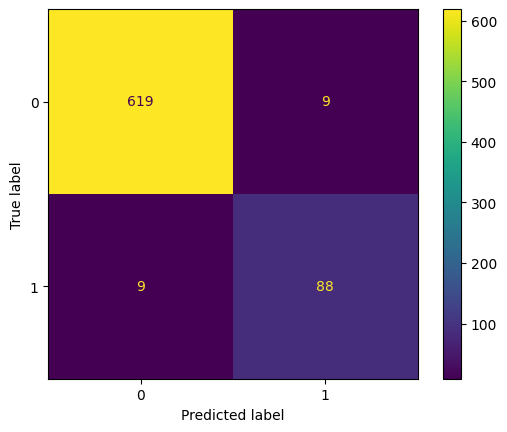

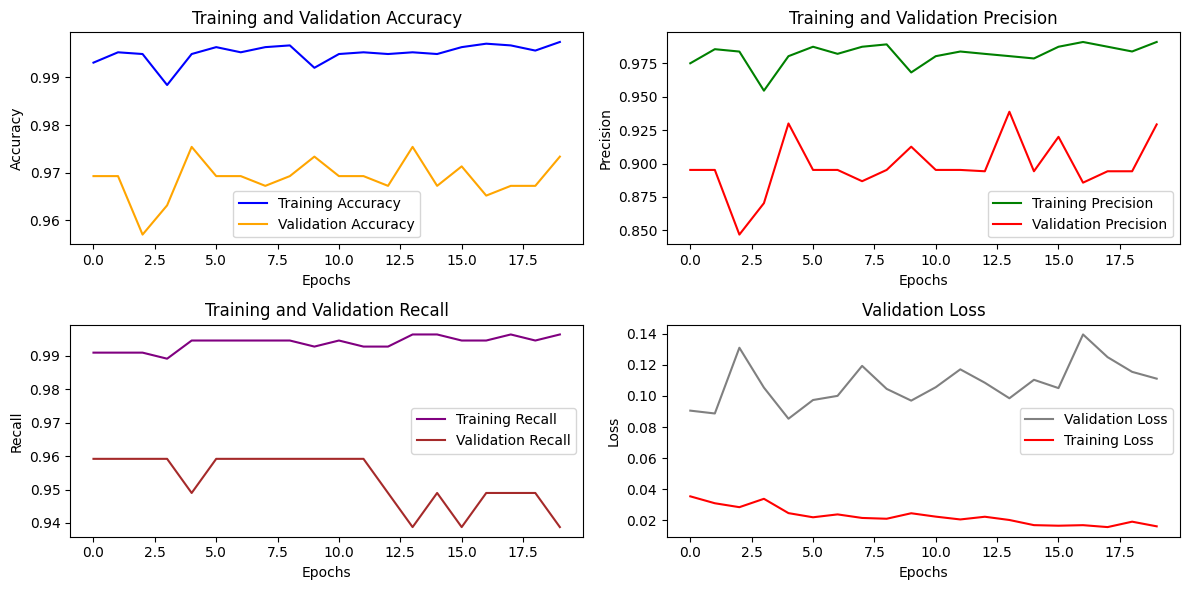

<keras.src.engine.sequential.Sequential object at 0x7853fc105ea0> logged with name : default...
Epoch 1/20
44/44 [==============================] - 2s 17ms/step - loss: 0.0308 - accuracy: 0.9935 - precision: 0.9751 - recall: 0.9928 - val_loss: 0.1012 - val_accuracy: 0.9734 - val_precision: 0.9126 - val_recall: 0.9592
Epoch 2/20
44/44 [==============================] - 1s 13ms/step - loss: 0.0233 - accuracy: 0.9935 - precision: 0.9734 - recall: 0.9946 - val_loss: 0.0973 - val_accuracy: 0.9775 - val_precision: 0.9579 - val_recall: 0.9286
Epoch 3/20
44/44 [==============================] - 1s 12ms/step - loss: 0.0294 - accuracy: 0.9917 - precision: 0.9698 - recall: 0.9891 - val_loss: 0.1254 - val_accuracy: 0.9652 - val_precision: 0.8785 - val_recall: 0.9592
Epoch 4/20
44/44 [==============================] - 1s 12ms/step - loss: 0.0201 - accuracy: 0.9982 - precision: 0.9946 - recall: 0.9964 - val_loss: 0.1146 - val_accuracy: 0.9713 - val_precision: 0.9038 - val_recall: 0.9592
Epoch 5/20
4

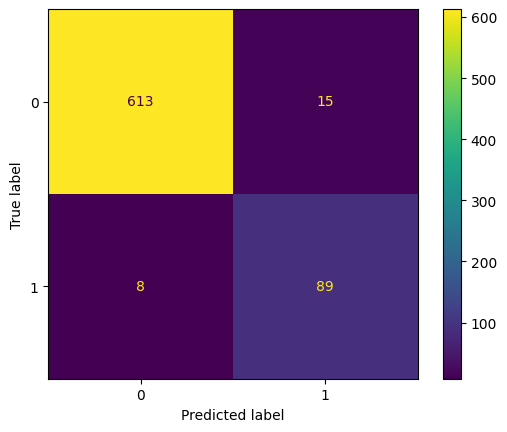

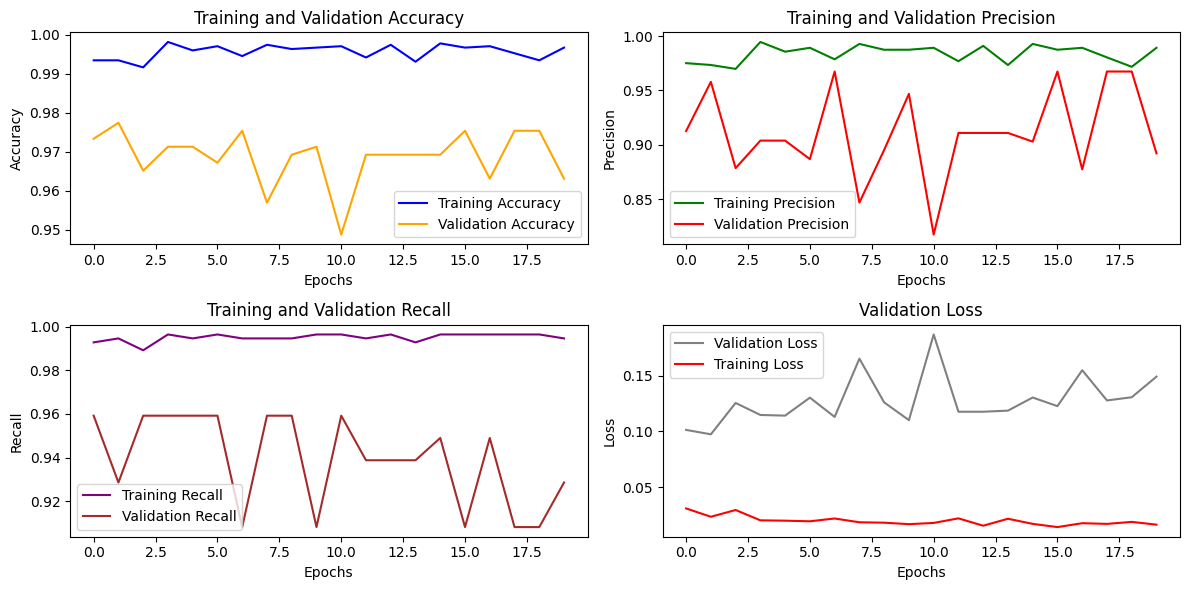

<keras.src.engine.sequential.Sequential object at 0x7853e876d8d0> logged with name : default...
Epoch 1/20
44/44 [==============================] - 4s 28ms/step - loss: 0.0261 - accuracy: 0.9935 - precision: 0.9734 - recall: 0.9946 - val_loss: 0.1058 - val_accuracy: 0.9775 - val_precision: 0.9394 - val_recall: 0.9490
Epoch 2/20
44/44 [==============================] - 1s 19ms/step - loss: 0.0201 - accuracy: 0.9960 - precision: 0.9856 - recall: 0.9946 - val_loss: 0.1103 - val_accuracy: 0.9754 - val_precision: 0.9300 - val_recall: 0.9490
Epoch 3/20
44/44 [==============================] - 1s 20ms/step - loss: 0.0184 - accuracy: 0.9960 - precision: 0.9839 - recall: 0.9964 - val_loss: 0.1147 - val_accuracy: 0.9713 - val_precision: 0.9118 - val_recall: 0.9490
Epoch 4/20
44/44 [==============================] - 1s 15ms/step - loss: 0.0185 - accuracy: 0.9978 - precision: 0.9928 - recall: 0.9964 - val_loss: 0.1257 - val_accuracy: 0.9672 - val_precision: 0.8868 - val_recall: 0.9592
Epoch 5/20
4

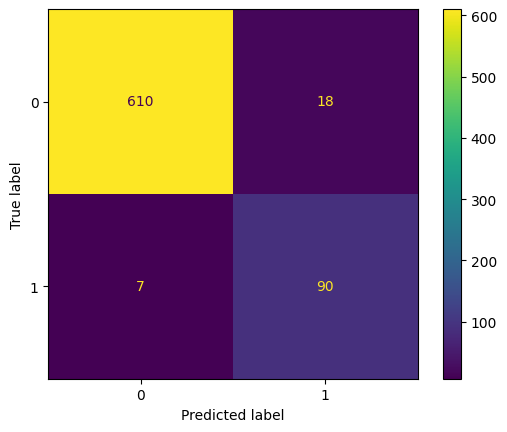

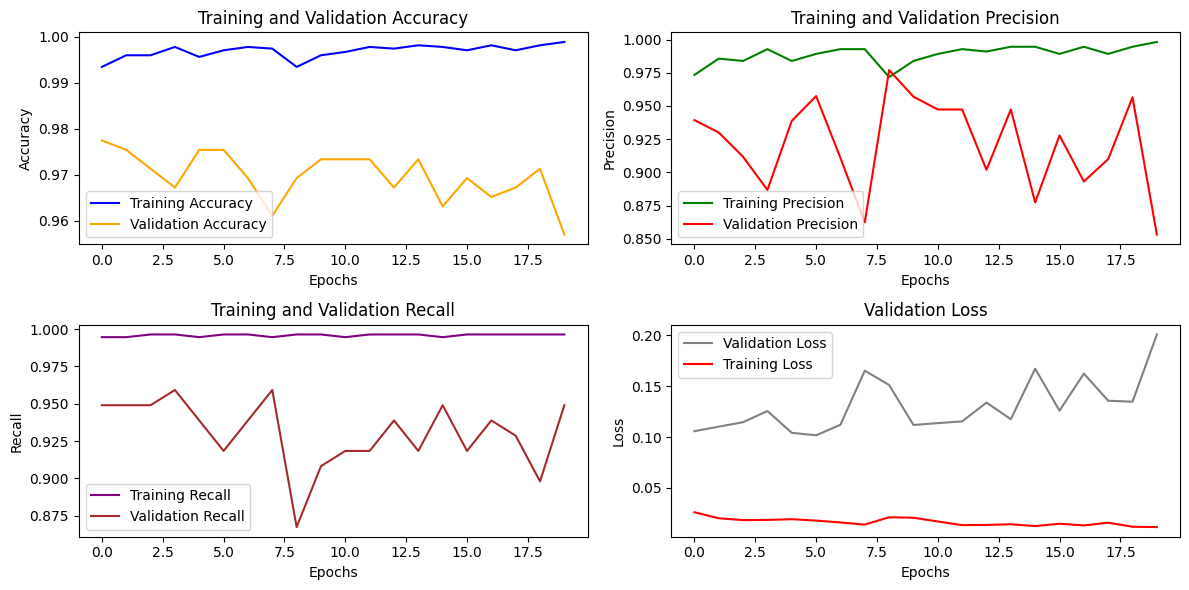

                                               Model  Accuracy  Precision  \
0  <keras.src.engine.sequential.Sequential object...  0.969655   0.850467   
1  <keras.src.engine.sequential.Sequential object...  0.975172   0.907216   
2  <keras.src.engine.sequential.Sequential object...  0.968276   0.855769   
3  <keras.src.engine.sequential.Sequential object...  0.965517   0.833333   

     Recall  
0  0.938144  
1  0.907216  
2  0.917526  
3  0.927835  


In [25]:


results_df= pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall'])
for model in [model_1, model_2, model_3,model_4]:
  tensorboard_callback = compile(model)
  training_analysis_weights(model,test_batch, train_batch, tensorboard_callback, weights)

print(results_df)

Les métriques sont élevées mais instables car elle fluctuent beaucoup trop et la loss de l'ensemble de validation ne diminue pas. Pour le moment nous concervons la méthode d'undersampling et nous allons vérifier si une méthode d'oversampling permet d'obtenir de meilleurs résulats.

In [26]:
# verification de quelles valeurs binaires sont associées au ham et au spam
print(data['v1'].value_counts())
print(data['v1'])

0    4825
1     747
Name: v1, dtype: int64
0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: v1, Length: 5572, dtype: int64


In [27]:
print(data_train_test.shape)

(4847, 5)


In [28]:

def data_over_sampling(data, nb_increase):
    """
    Sur-échantillonnage des données pour équilibrer les classes.

    Args:
    - data (DataFrame): Le DataFrame contenant les données.
    - nb_increase (int): Le facteur d'augmentation pour la classe minoritaire.

    Returns:
    - DataFrame: Le DataFrame équilibré après sur-échantillonnage.
    """
    data_sample_1 = data.loc[data['v1'] == 'ham', :]
    len_class_sub = len(data_sample_1)
    data_sample_2 = data.loc[data['v1'] == 'spam', :].sample(nb_increase * len_class_sub, replace=True)

    return pd.concat([data_sample_1, data_sample_2], axis=0).sample(frac=1).reset_index(drop=True)

# Exemple d'utilisation
data_increase = data_over_sampling(data_train_test, 2)
print(data_increase.shape)
print(data_increase['v1'].value_counts())


(12591, 5)
spam    8394
ham     4197
Name: v1, dtype: int64


results_df Empty DataFrame
Columns: [Model, Accuracy, Precision, Recall]
Index: []
<keras.src.engine.sequential.Sequential object at 0x7853ec857190> logged with name : default...
Epoch 1/20
168/168 [==============================] - 3s 10ms/step - loss: 0.0434 - accuracy: 0.9883 - precision: 0.9927 - recall: 0.9898 - val_loss: 0.0345 - val_accuracy: 0.9899 - val_precision: 0.9976 - val_recall: 0.9873
Epoch 2/20
168/168 [==============================] - 1s 9ms/step - loss: 0.0288 - accuracy: 0.9902 - precision: 0.9945 - recall: 0.9907 - val_loss: 0.0218 - val_accuracy: 0.9910 - val_precision: 0.9960 - val_recall: 0.9905
Epoch 3/20
168/168 [==============================] - 2s 9ms/step - loss: 0.0212 - accuracy: 0.9930 - precision: 0.9961 - recall: 0.9934 - val_loss: 0.0193 - val_accuracy: 0.9926 - val_precision: 0.9984 - val_recall: 0.9905
Epoch 4/20
168/168 [==============================] - 2s 13ms/step - loss: 0.0168 - accuracy: 0.9939 - precision: 0.9963 - recall: 0.9945 - val_loss

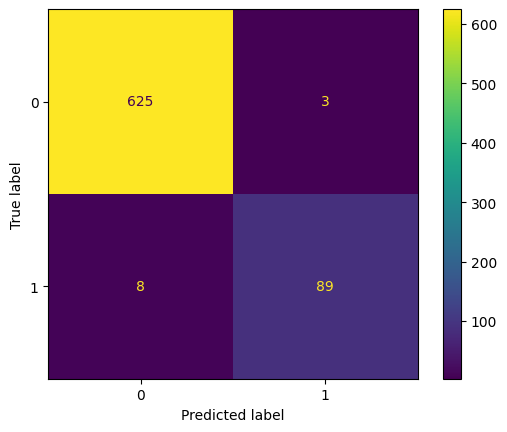

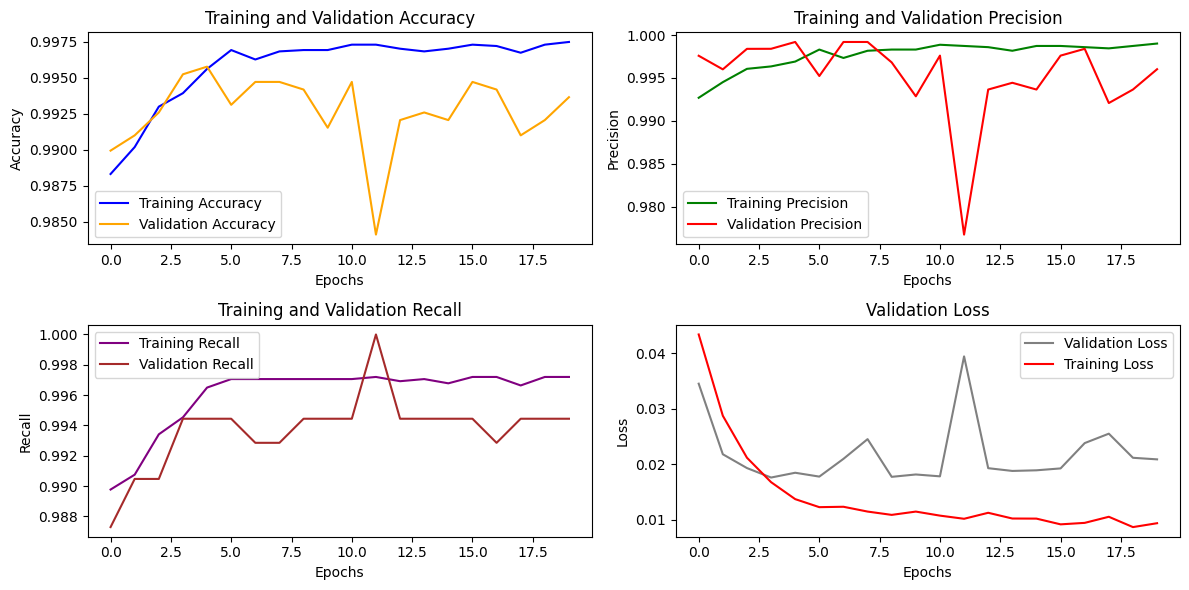

<keras.src.engine.sequential.Sequential object at 0x7853f983b460> logged with name : default...
Epoch 1/20
168/168 [==============================] - 3s 13ms/step - loss: 0.0430 - accuracy: 0.9886 - precision: 0.9932 - recall: 0.9896 - val_loss: 0.0334 - val_accuracy: 0.9873 - val_precision: 0.9936 - val_recall: 0.9873
Epoch 2/20
168/168 [==============================] - 2s 13ms/step - loss: 0.0298 - accuracy: 0.9900 - precision: 0.9935 - recall: 0.9915 - val_loss: 0.0230 - val_accuracy: 0.9915 - val_precision: 0.9976 - val_recall: 0.9897
Epoch 3/20
168/168 [==============================] - 2s 9ms/step - loss: 0.0211 - accuracy: 0.9927 - precision: 0.9950 - recall: 0.9941 - val_loss: 0.0220 - val_accuracy: 0.9921 - val_precision: 0.9984 - val_recall: 0.9897
Epoch 4/20
168/168 [==============================] - 2s 10ms/step - loss: 0.0162 - accuracy: 0.9950 - precision: 0.9965 - recall: 0.9959 - val_loss: 0.0193 - val_accuracy: 0.9910 - val_precision: 0.9921 - val_recall: 0.9944
Epoch

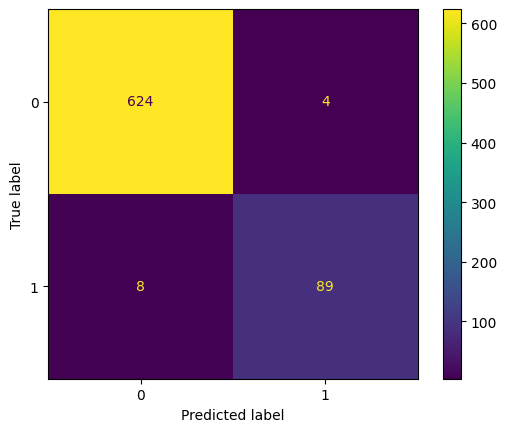

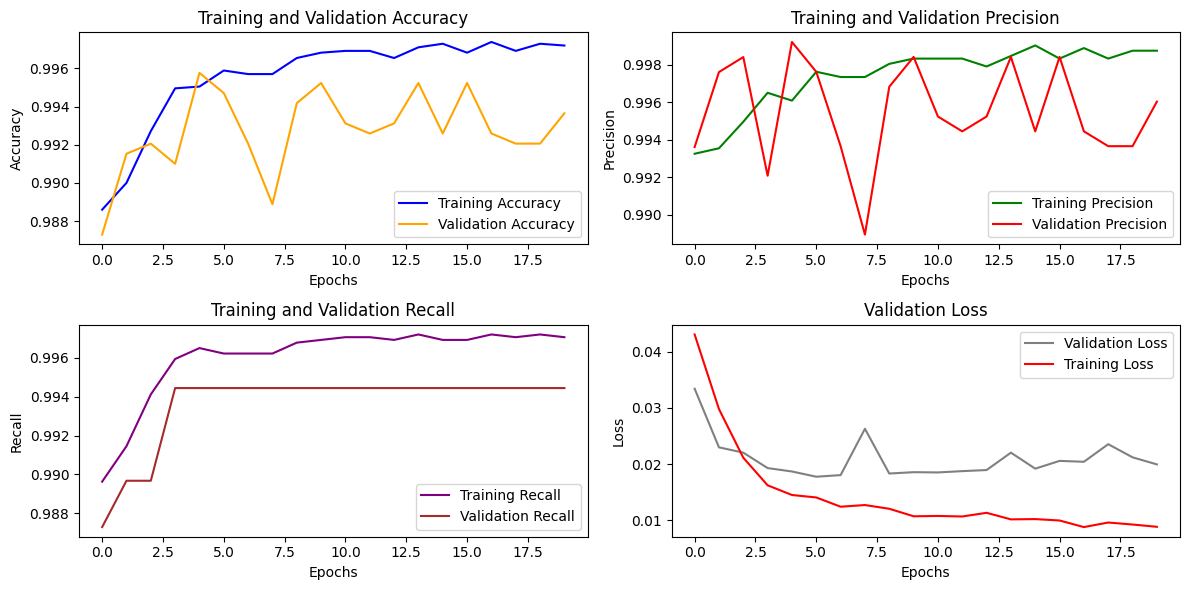

<keras.src.engine.sequential.Sequential object at 0x7853fc105ea0> logged with name : default...
Epoch 1/20
168/168 [==============================] - 3s 11ms/step - loss: 0.0425 - accuracy: 0.9886 - precision: 0.9939 - recall: 0.9889 - val_loss: 0.0311 - val_accuracy: 0.9905 - val_precision: 0.9984 - val_recall: 0.9873
Epoch 2/20
168/168 [==============================] - 2s 9ms/step - loss: 0.0248 - accuracy: 0.9922 - precision: 0.9961 - recall: 0.9922 - val_loss: 0.0176 - val_accuracy: 0.9931 - val_precision: 0.9968 - val_recall: 0.9929
Epoch 3/20
168/168 [==============================] - 2s 9ms/step - loss: 0.0170 - accuracy: 0.9949 - precision: 0.9965 - recall: 0.9958 - val_loss: 0.0315 - val_accuracy: 0.9899 - val_precision: 1.0000 - val_recall: 0.9849
Epoch 4/20
168/168 [==============================] - 2s 9ms/step - loss: 0.0135 - accuracy: 0.9953 - precision: 0.9969 - recall: 0.9961 - val_loss: 0.0164 - val_accuracy: 0.9958 - val_precision: 0.9992 - val_recall: 0.9944
Epoch 5

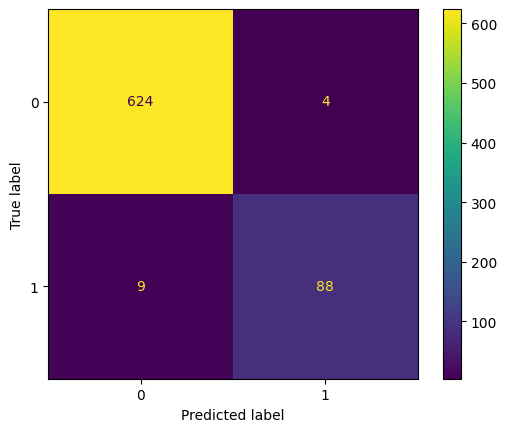

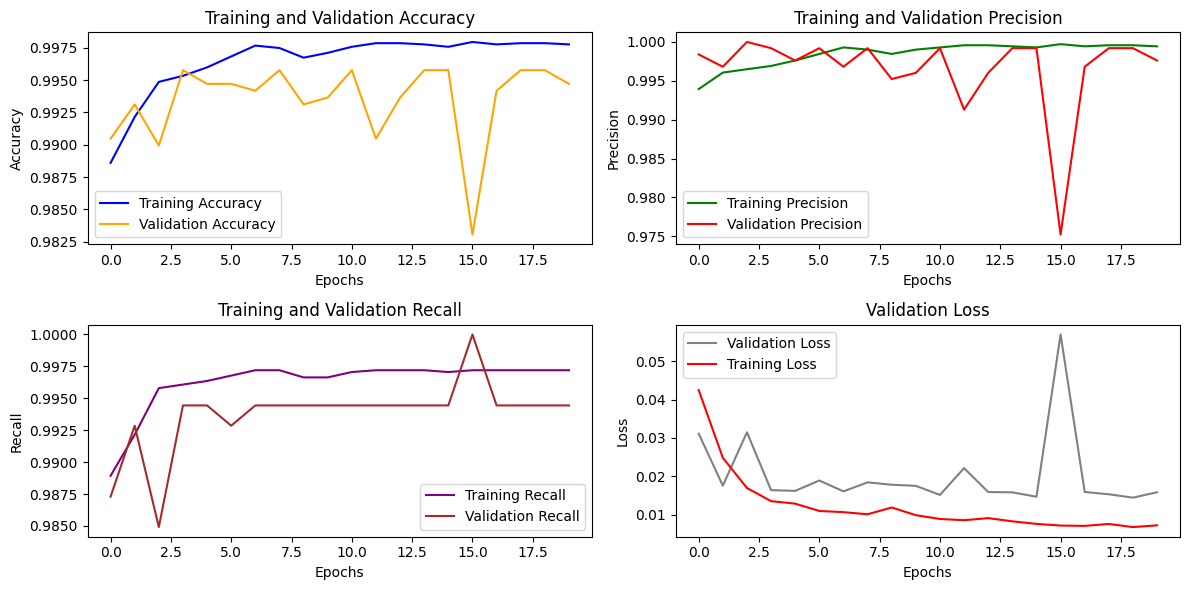

<keras.src.engine.sequential.Sequential object at 0x7853e876d8d0> logged with name : default...
Epoch 1/20
168/168 [==============================] - 3s 11ms/step - loss: 0.0418 - accuracy: 0.9888 - precision: 0.9953 - recall: 0.9878 - val_loss: 0.0335 - val_accuracy: 0.9905 - val_precision: 1.0000 - val_recall: 0.9857
Epoch 2/20
168/168 [==============================] - 2s 12ms/step - loss: 0.0251 - accuracy: 0.9919 - precision: 0.9966 - recall: 0.9912 - val_loss: 0.0203 - val_accuracy: 0.9936 - val_precision: 1.0000 - val_recall: 0.9905
Epoch 3/20
168/168 [==============================] - 3s 15ms/step - loss: 0.0157 - accuracy: 0.9949 - precision: 0.9969 - recall: 0.9954 - val_loss: 0.0170 - val_accuracy: 0.9963 - val_precision: 1.0000 - val_recall: 0.9944
Epoch 4/20
168/168 [==============================] - 2s 11ms/step - loss: 0.0127 - accuracy: 0.9963 - precision: 0.9980 - recall: 0.9964 - val_loss: 0.0160 - val_accuracy: 0.9958 - val_precision: 0.9992 - val_recall: 0.9944
Epoc

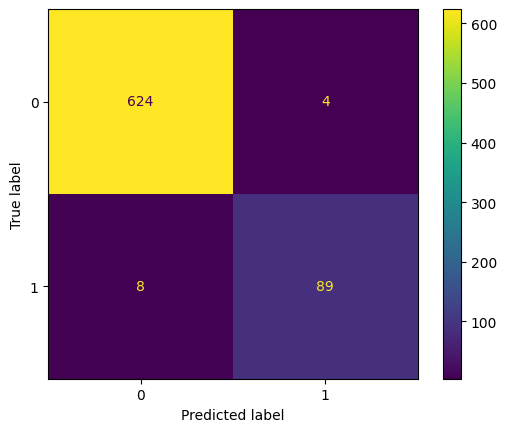

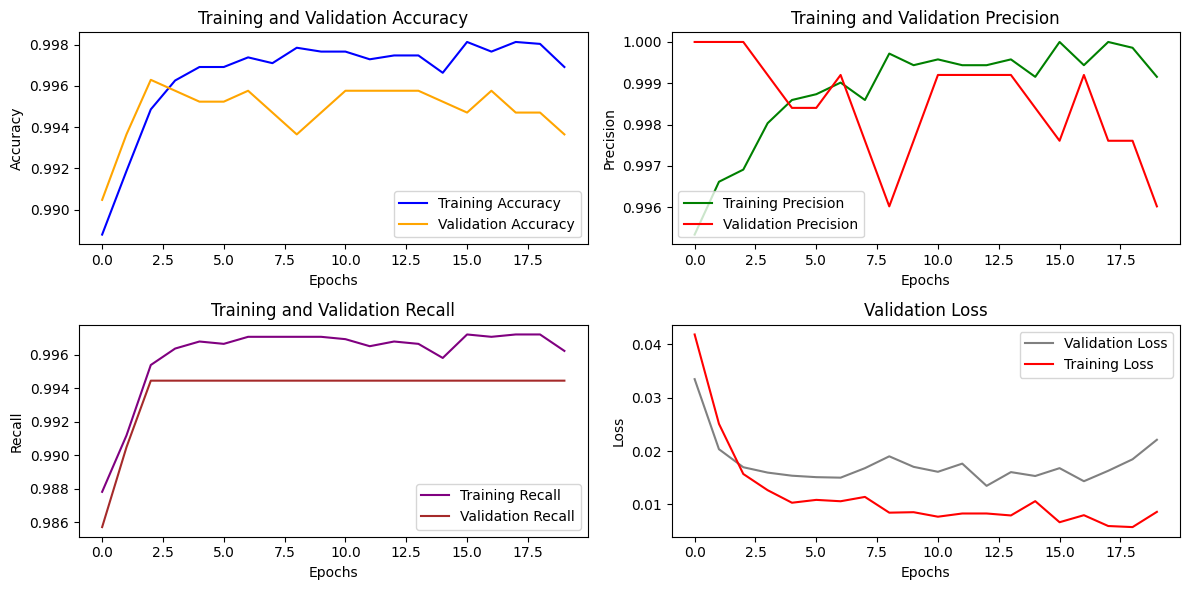

                                               Model  Accuracy  Precision  \
0  <keras.src.engine.sequential.Sequential object...  0.984828   0.967391   
1  <keras.src.engine.sequential.Sequential object...  0.983448   0.956989   
2  <keras.src.engine.sequential.Sequential object...  0.982069   0.956522   
3  <keras.src.engine.sequential.Sequential object...  0.983448   0.956989   

     Recall  
0  0.917526  
1  0.917526  
2  0.907216  
3  0.917526  


In [29]:
v2_pad_train = tf.keras.preprocessing.sequence.pad_sequences(data_increase['v2_tokenized'], padding="post", maxlen=max_len_sentence)
y_train_test = preprocessor_y.transform(data_increase['v1'])
x_train, x_test, y_train, y_test = train_test_split(v2_pad_train, y_train_test, test_size=0.15, stratify=y_train_test, random_state=2)
BATCH_SIZE = 64
train_batch = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(BATCH_SIZE)
test_batch = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall'])
print("results_df",results_df)
for model in [model_1, model_2, model_3,model_4]:
  tensorboard_callback = compile(model)
  training_analysis(model,test_batch, train_batch, tensorboard_callback)

print(results_df)

Comme pour le test avec les pondérations, les évolutions des métriques pour l'ensemble de validation sont complètement instables. Les approches d'undersampling et d'entrainement avec architecture du modèle 4 semblent être les meilleures pour obtenir des performances acceptables.

#### Modèles RNN

Un modèle RNN est un type spécifique de modèle séquentiel, mais avec une caractéristique spéciale qu'est la récurrence.
Les RNN sont conçus pour traiter des séquences de données en tenant compte de l'ordre et en mémorisant l'information antérieure à travers des états cachés.
Ils sont particulièrement utiles pour travailler avec des données séquentielles comme des séquences de mots dans un texte.

On va tester un premier modèle en utilisant des couches simple RNN, puis un deuxième en rajoutant une couche dropout et deux autres modèles en utilisant des couches LSTM et GRU.


In [30]:
model_1 = tf.keras.Sequential([
                  # Word Embedding layer
                  Embedding(vocab_size+1, 64, input_shape=[data[['v1']].shape[1],],name="embedding"),
                  # Gobal average pooling
                  SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
                  SimpleRNN(units=32, return_sequences=False), # returns the last output
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  # output layer with as many neurons as the number of classes
                  # for the target variable and softmax activation
                  Dense(5, activation="softmax")
])

model_2 = tf.keras.Sequential([
    Embedding(vocab_size+1, 64, input_shape=[data[['v1']].shape[1],], name="embedding"),
    SimpleRNN(units=64, return_sequences=True),
    Dropout(0.5),  # Ajout de dropout
    SimpleRNN(units=32, return_sequences=False),
    Dense(16, activation='relu'),
    Dropout(0.5),  # Ajout de dropout
    Dense(8, activation='relu'),
    Dense(5, activation="softmax")
])


model_3 = tf.keras.Sequential([
                  # Word Embedding layer
                  Embedding(vocab_size+1, 64, input_shape=[data[['v1']].shape[1],],name="embedding"),
                  # Gobal average pooling
                  LSTM(units=64, return_sequences=True),
                  LSTM(units=32, return_sequences=False),
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  # output layer with as many neurons as the number of classes
                  # for the target variable and softmax activation
                  Dense(5, activation="softmax")
])

model_4 = tf.keras.Sequential([
                  # Word Embedding layer
                  Embedding(vocab_size+1, 64, input_shape=[data[['v1']].shape[1],],name="embedding"),
                  # Gobal average pooling
                  GRU(units=64, return_sequences=True),
                  GRU(units=32, return_sequences=False),
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  # output layer with as many neurons as the number of classes
                  # for the target variable and softmax activation
                  Dense(5, activation="softmax")
])


for model in [model_1, model_2, model_3,model_4]:
  model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 64)             128064    
                                                                 
 simple_rnn (SimpleRNN)      (None, 1, 64)             8256      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_11 (Dense)            (None, 16)                528       
                                                                 
 dense_12 (Dense)            (None, 8)                 136       
                                                                 
 dense_13 (Dense)            (None, 5)                 45        
                                                                 
Total params: 140133 (547.39 KB)
Trainable params: 140

In [31]:
# on applique le padding
v2_pad_train = tf.keras.preprocessing.sequence.pad_sequences(data_red['v2_tokenized'], padding="post", maxlen=max_len_sentence)

preprocessor_y = LabelEncoder()
y_train_test = preprocessor_y.fit_transform(data_red['v1'])
y_val = preprocessor_y.transform(data_val['v1'])
x_train, x_test, y_train, y_test = train_test_split(v2_pad_train, y_train_test, test_size=0.15, stratify=y_train_test, random_state=2)

BATCH_SIZE = 64
train_batch = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(BATCH_SIZE)
test_batch = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)


results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall'])
print("results_df",results_df)
for model in [model_1, model_2, model_3,model_4]:
  tensorboard_callback = compile(model)
  training_analysis(model,test_batch, train_batch, tensorboard_callback)

print(results_df)

results_df Empty DataFrame
Columns: [Model, Accuracy, Precision, Recall]
Index: []
<keras.src.engine.sequential.Sequential object at 0x7853e04936a0> logged with name : default...
Epoch 1/20


ValueError: ignored

In [ ]:


print("results_df",results_df)
for model in [model_1, model_2, model_3,model_4]:
  tensorboard_callback = compile(model)
  training_analysis(model,test_batch, train_batch, tensorboard_callback)

print(results_df)